In [2]:
import os
import pandas as pd
from bertopic import BERTopic
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

c:\Users\gozde\.conda\envs\nlp\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Extracting CRAFT mentions

In [3]:
onto_data_path = '../CRAFT/data/'

In [4]:
ontologies = os.listdir(onto_data_path)
ontologies = [o for o in ontologies if os.path.isdir(os.path.join(onto_data_path, o))]

In [5]:
dfs = []
for o in ontologies:
    dfs.append(pd.read_csv(os.path.join(onto_data_path, o, "annotations.csv"))[['PMID', 'MentionTextSegment']])
mentions = pd.concat(dfs)
mentions = mentions.groupby('PMID').apply(lambda x: (list(x.MentionTextSegment.drop_duplicates())))

In [6]:
mentions = mentions.to_frame().reset_index().rename(columns={0: 'mentions'})

In [7]:
lens = mentions.apply(lambda x: len(x))

In [8]:
mentions

,PMID,mentions
0,11319941,"[neuron, striatum neuron, biological regulatio..."
1,11532192,"[biological pigment, aging, circadian rhythm, ..."
2,11597317,[double-strand break repair via homologous rec...
3,11604102,"[gene expression, spermatogenesis, translation..."
4,11897010,"[cation, ion, alternative mRNA splicing, via s..."
...,...,...
92,17565376,"[T cell, M cell of gut, Peyer's patch developm..."
93,17590087,"[Purkinje cell, gene expression, autosome, Hom..."
94,17608565,"[acetylcholine, neuron, amacrine cell, interne..."
95,17677002,"[polyatomic entity, neuron, gene expression, b..."


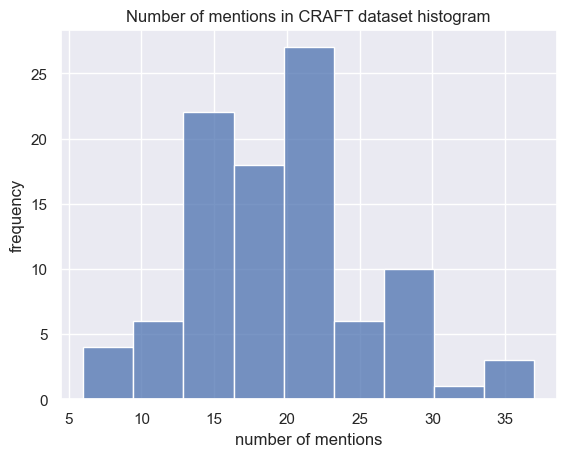

In [12]:
fig, ax = plt.subplots(1,1)
sns.set_theme()
sns.histplot(mentions.mentions.apply(lambda x: len(x)), ax = ax)
ax.set_xlabel('number of mentions')
ax.set_ylabel('frequency')
ax.set_title('Number of mentions in CRAFT dataset histogram')
plt.show()

# Training

### BERTopic

In [9]:
def transform_strings_to_arrays(df, col_names = ['tokenized_sentences', 'tokenized_words', 'tokenized_words_processed', 'tokenized_words_lemmatize']):
    for col in col_names:
        df[col] = df[col].apply(eval)
    return df

In [77]:
# basic BertTopic keyword extraction
def train_transform(train_data, top_n_words, min_topic_size):
    
    # train transform
    topic_model = BERTopic(min_topic_size=min_topic_size, top_n_words=top_n_words)
    topics, probs = topic_model.fit_transform(train_data.values)

    return topic_model, topics, probs

In [78]:
def get_bertopic_keywords(data_path, top_n_words, min_topic_size):
    full_data = transform_strings_to_arrays(pd.read_csv(data_path))
    data = full_data.groupby(by = ['PMID'])['tokenized_words_lemmatize'].agg(lambda x: ' '.join(x.values[0] + x.values[1]))
    topic_model, topics, probs = train_transform(data, top_n_words, min_topic_size)
    bertopic_keywords = pd.DataFrame({'PMID': list(data.index), 'topic_number': topics})
    bertopic_keywords['keywords'] = bertopic_keywords['topic_number'].apply(lambda t_num: [kw[0] for kw in topic_model.get_topic(t_num)])
    return bertopic_keywords[['PMID', 'keywords']]

### LDA

In [12]:
def get_lda_results(data_path, num_topics = 10,num_keywords = 10, full = False):
    from gensim import corpora, models
    import os
    import pandas as pd
    """Performs lda keywords extraction for data after lemmatization.

    Parameters
    ----------
    data_path : str
        Path to preprocessed dataset. Dataset must contain a column with name 'tokenized_words_lemmatize'.

    num_topic : int
        Number of disired topics

    num_keywords : int
        Number of keywords per topic

    Returns
    ------
    result : DataFrame (if fill is False)
        DataFrame with reults
    result, topic_distribution,lda_model : (DataFrame,DataFrame,model) (if full is True)
        DataFrame with reults, DataFrae with topic distribution and lda_model

    """

    def get_topic_distribution(lda_model, number_of_topics, number_of_keywords):
        topics_distrib = {}
        for t in lda_model.print_topics(number_of_topics,number_of_keywords):
            topics_distrib[t[0]] =[(a.split('*')[1][1:-1],float(a.split("*")[0])) for a in t[1].split(' + ')]
        return topics_distrib


    data = pd.read_csv(data_path)
    columns = ['tokenized_sentences', 'tokenized_words_lemmatize']
    for col in columns:
        data[col] = data[col].apply(eval)

    texts = data.groupby('PMID')['tokenized_words_lemmatize'].agg(lambda x: x.iloc[0]+x.iloc[1])
    dictionary = corpora.Dictionary(texts)
    corpus = [dictionary.doc2bow(text) for text in texts]

    
    lda_model = models.LdaMulticore(corpus=corpus,
                                        id2word=dictionary,
                                        num_topics=num_topics,
                                        passes = 20)
    doc_lda = lda_model[corpus]

    topic_distribution = get_topic_distribution(lda_model,num_topics,num_keywords)
    topics_results = pd.DataFrame.from_records([topic_distribution]).T.reset_index().rename(columns = {'index':'topic_number',0:'topic_keywords'})
    topics_results['keywords'] = topics_results['topic_keywords'].apply(lambda x: [a[0] for a in x])

    

    docs= []
    for doc in doc_lda:
        docs.append({
            'topic_number':doc[0][0],
            'topic_probs': float(doc[0][1]),
            'topic_keywords': topics_results.iloc[doc[0][0]]['topic_keywords'],
            'keywords': topics_results.iloc[doc[0][0]]['keywords']

        })

    docs = pd.DataFrame.from_records(docs)

    results = data[['PMID']].drop_duplicates().reset_index(drop=True).join(docs)
    topics_results = pd.DataFrame.from_records([topic_distribution]).T.reset_index().rename(columns = {'index':'topic_number',0:'topic_keywords'})



    if full:
        return results,topics_results, lda_model
    return results[['PMID','topic_number','keywords']]
    

# Evaluation on CRAFT dataset

### Evaluation functions

In [13]:
def tp(y, y_hat):
    tps = []
    for i in range(len(y)):
        tps.append(np.sum([pmid_y_hat in ', '.join(y[i]) for pmid_y_hat in y_hat[i]]))
    return tps
    

In [14]:
def fp(y, y_hat):
    fps = []
    for i in range(len(y)):
        fps.append(np.sum([pmid_y_hat not in ', '.join(y[i]) for pmid_y_hat in y_hat[i]]))
    return fps

In [15]:
def fn(y, y_hat):
    fns = []
    for i in range(len(y)):
        fns.append(np.sum([pmid_y not in ', '.join(y_hat[i]) for pmid_y in y[i]]))
    return fns

In [16]:
def get_p_r_f1(y, y_hat):
    tp_all = np.sum(tp(y, y_hat))
    fp_all = np.sum(fp(y, y_hat))
    fn_all = np.sum(fn(y, y_hat)) 

    prec = tp_all / (tp_all + fp_all)
    rec = tp_all / (tp_all + fn_all)
    f1 = 2 / (1/prec + 1/rec)

    return prec, rec, f1

### BERTopic and LDA metrics on the number of keywords extracted

In [17]:
data_path = "../CRAFT/data/data_whole.csv"

y = mentions.mentions
top_n_words_seq = range(1, 31)

In [19]:
# BERTopic
bt_precs = np.zeros(len(top_n_words_seq))
bt_recs = np.zeros(len(top_n_words_seq))
bt_f1s = np.zeros(len(top_n_words_seq))
bt_keywords = []
for i, top_n_words in enumerate(top_n_words_seq):
    kws = get_bertopic_keywords(data_path, top_n_words=top_n_words, min_topic_size=3).keywords
    bt_keywords.append(kws)
    bt_precs[i], bt_recs[i], bt_f1s[i] = get_p_r_f1(y, kws)

In [20]:
# LDA
lda_precs = np.zeros(len(top_n_words_seq))
lda_recs = np.zeros(len(top_n_words_seq))
lda_f1s = np.zeros(len(top_n_words_seq))
lda_kws = []
for i, top_n_words in enumerate(top_n_words_seq):
    kws = get_lda_results(data_path, num_topics=9, num_keywords=top_n_words).keywords
    lda_kws.append(kws)
    lda_precs[i], lda_recs[i], lda_f1s[i] = get_p_r_f1(y, kws)
    

Text(0.5, 1.0, 'LDA metrics')

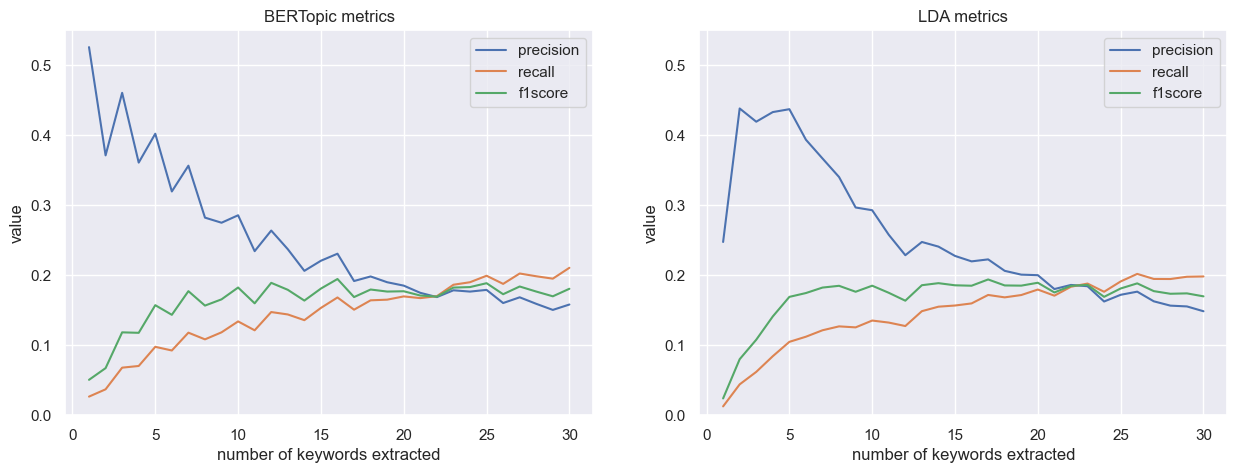

In [24]:
fig, axes = plt.subplots(1,2, figsize=(15, 5))
sns.set_theme()

# BERTopic
axes[0].set_ylim([0, 0.55])
axes[0].plot(top_n_words_seq, bt_precs)
axes[0].plot(top_n_words_seq, bt_recs)
axes[0].plot(top_n_words_seq, bt_f1s)

axes[0].legend(['precision', 'recall', 'f1score'])
axes[0].set_ylabel('value')
axes[0].set_xlabel('number of keywords extracted')
axes[0].set_title('BERTopic metrics')

# LDA
axes[1].set_ylim([0, 0.55])
axes[1].plot(top_n_words_seq, lda_precs)
axes[1].plot(top_n_words_seq, lda_recs)
axes[1].plot(top_n_words_seq, lda_f1s)

axes[1].legend(['precision', 'recall', 'f1score'])
axes[1].set_ylabel('value')
axes[1].set_xlabel('number of keywords extracted')
axes[1].set_title('LDA metrics')

### Metrics on the number of keywords extracted - example for BERTopic for 22 keywords

In [58]:
number_of_keywords_idx = 21
max_idx = np.argmax(tp(y, bt_keywords[number_of_keywords_idx]))
min_idx = np.argmin(tp(y, bt_keywords[number_of_keywords_idx]))

print(f'max tp: {np.max(tp(y, bt_keywords[number_of_keywords_idx]))}')
print(f'min tp: {np.min(tp(y, bt_keywords[number_of_keywords_idx]))}')

max tp: 10
min tp: 0


In [44]:
y[max_idx]

['polyatomic entity',
 'germ cell',
 'primordial germ cell',
 'oocyte',
 'sperm',
 'egg cell',
 'embryonic stem cell',
 'embryonic cell',
 'cell fate specification',
 'gene expression',
 'gastrulation',
 'germ cell development',
 'embryo development',
 'fertilization',
 'embryonic cleavage',
 'Mus',
 'Metazoa',
 'Mammalia',
 'Diptera',
 'developmental pluripotency-associated protein 3',
 'gene',
 'embryo',
 'adult organism',
 'gonad',
 'cell layer',
 '4 cell stage',
 'cleavage stage']

In [50]:
bt_keywords[number_of_keywords_idx][max_idx]

['cell',
 'mouse',
 'gene',
 'expression',
 'embryonic',
 'embryo',
 'development',
 'sex',
 'reporter',
 'growth',
 'chromatin',
 'mutant',
 'recombination',
 'protein',
 'germ',
 'heterochromatin',
 'pten',
 'abstract',
 'signaling',
 'stem',
 'stage',
 'loss']

In [51]:
y[min_idx]

['gene expression',
 'parturition',
 'death',
 'fertilization',
 'neurogenesis',
 'proteolysis',
 'extracellular matrix',
 'membrane',
 'Mus',
 'Homo sapiens',
 'Mammalia',
 'disintegrin and metalloproteinase domain-containing protein 22',
 'polypeptide_domain',
 'gene',
 'nerve',
 'cerebral cortex',
 'cerebellum',
 'nervous system']

In [52]:
bt_keywords[number_of_keywords_idx][min_idx]

['itpr1',
 'axon',
 'adam11',
 'adam22',
 'ataxia',
 'seizure',
 'mouse',
 'observed',
 'disorder',
 'deletion',
 'result',
 'molecule',
 'brunol4',
 'gjc',
 'task',
 'peripheral',
 'mutation',
 'show',
 'human',
 'epilepsy',
 'homozygote',
 'calvarial']

### Metrics on the number of keywords extracted - example for LDA for 22 keywords

In [59]:
number_of_keywords_idx = 21
max_idx = np.argmax(tp(y, lda_kws[number_of_keywords_idx]))
min_idx = np.argmin(tp(y, lda_kws[number_of_keywords_idx]))

print(f'max tp: {np.max(tp(y, lda_kws[number_of_keywords_idx]))}')
print(f'min tp: {np.min(tp(y, lda_kws[number_of_keywords_idx]))}')

max tp: 11
min tp: 1


In [60]:
y[max_idx]

['sensory hair cell',
 'supportive cell',
 'cell differentiation',
 'gene expression',
 'sensory system development',
 'sensory organ development',
 'sensory perception of sound',
 'biological regulation',
 'Notch signaling pathway',
 'lateral inhibition',
 'cell cycle',
 'Mammalia',
 'protein jagged-1',
 'delta-like protein 1',
 'protein jagged-2',
 'transcription factor SOX-2',
 'cyclin-dependent kinase inhibitor 1B',
 'gene',
 'embryo',
 'internal ear',
 'sense organ',
 'macula',
 'ear',
 'cochlea',
 'utricle of membranous labyrinth',
 'macula of saccule of membranous labyrinth',
 'spiral organ of cochlea',
 'crista ampullaris']

In [61]:
lda_kws[number_of_keywords_idx][max_idx]

['mouse',
 'cell',
 'gene',
 'mutant',
 'expression',
 'Abstract',
 'development',
 'individual',
 'sensory',
 'mutation',
 'transcription',
 'factor',
 'show',
 'phenotype',
 'protein',
 'hair',
 'model',
 'antioxidant',
 'ear',
 'region',
 'allele',
 '1']

In [62]:
y[min_idx]

['biological pigment',
 'aging',
 'circadian rhythm',
 'biological regulation',
 'Mus',
 'Mammalia',
 'species',
 'Homo sapiens',
 'gene',
 'allele',
 'eye']

In [63]:
lda_kws[number_of_keywords_idx][min_idx]

['mouse',
 'cell',
 'receptor',
 'strain',
 'differentiation',
 'IOP',
 'signaling',
 'D2',
 'bone',
 'gene',
 'function',
 'chromosome',
 'Abstract',
 'apoptotic',
 'time',
 'SirT1',
 'dopamine',
 'development',
 'Ptdsr',
 'response',
 'taste',
 'phenotype']

# Hyperparams influence

### BERTopic - different minimal number of datapoints in cluster

In [80]:
min_topic_size_seq = [3, 4, 5, 6, 7, 8, 9, 10]
top_n_words = 22

In [83]:
bt_precs = np.zeros(len(min_topic_size_seq))
bt_recs = np.zeros(len(min_topic_size_seq))
bt_f1s = np.zeros(len(min_topic_size_seq))
bt_keywords = []
for i, min_topic_size in enumerate(min_topic_size_seq):
    kws = get_bertopic_keywords(data_path, top_n_words=top_n_words, min_topic_size=min_topic_size).keywords
    bt_keywords.append(kws)
    bt_precs[i], bt_recs[i], bt_f1s[i] = get_p_r_f1(y, kws)

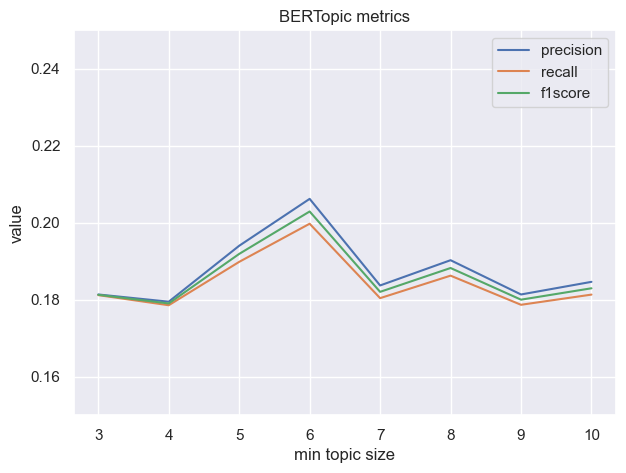

In [94]:
fig, axes = plt.subplots(1,1, figsize=(7, 5))
sns.set_theme()

axes.set_ylim([0.15, 0.25])
axes.plot(min_topic_size_seq, bt_precs)
axes.plot(min_topic_size_seq, bt_recs)
axes.plot(min_topic_size_seq, bt_f1s)

axes.legend(['precision', 'recall', 'f1score'])
axes.set_ylabel('value')
axes.set_xlabel('min topic size')
axes.set_title('BERTopic metrics')
plt.show()

### LDA - different numbers of topics

In [92]:
number_of_topics_seq = [3, 4, 5, 6, 7, 8, 9, 10]
top_n_words = 22

In [93]:
lda_precs = np.zeros(len(number_of_topics_seq))
lda_recs = np.zeros(len(number_of_topics_seq))
lda_f1s = np.zeros(len(number_of_topics_seq))
lda_kws = []
for i, number_of_topics in enumerate(number_of_topics_seq):
    kws = get_lda_results(data_path, num_topics=number_of_topics, num_keywords=top_n_words).keywords
    lda_kws.append(kws)
    lda_precs[i], lda_recs[i], lda_f1s[i] = get_p_r_f1(y, kws)

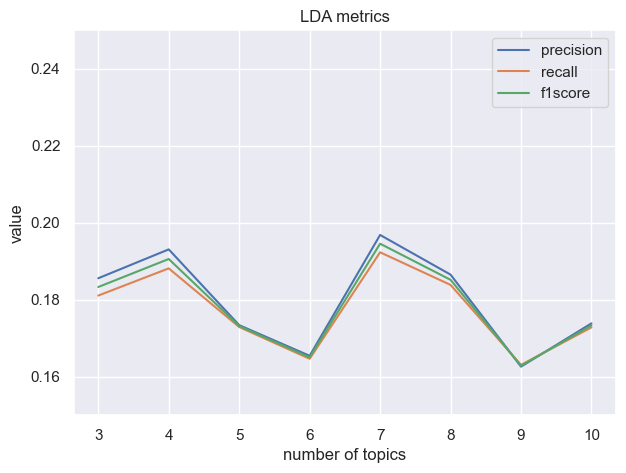

In [95]:
fig, axes = plt.subplots(1,1, figsize=(7, 5))
sns.set_theme()

axes.set_ylim([0.15, 0.25])
axes.plot(number_of_topics_seq, lda_precs)
axes.plot(number_of_topics_seq, lda_recs)
axes.plot(number_of_topics_seq, lda_f1s)

axes.legend(['precision', 'recall', 'f1score'])
axes.set_ylabel('value')
axes.set_xlabel('number of topics')
axes.set_title('LDA metrics')
plt.show()